# Non-Finetuned Transformer Models for Arabic Sentiment Analysis

This notebook implements four pre-trained transformer models for Arabic sentiment analysis without fine-tuning. We'll use the models directly from Hugging Face for inference.

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True) # Mount google drive to load training and testing data

PREPROCESSED_MERGED_DATASET_DIR = '/content/drive/MyDrive/Master1/Sentiment/PREPROCESSED_DATASET/'


Mounted at /content/drive


## 1. Setup and Imports

In [2]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from datasets import load_dataset, Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

# Set random seed for reproducibility
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## 2. Define Constants and Paths

In [3]:
# Constants
MAX_LEN = 80  # Maximum sequence length
BATCH_SIZE = 32  # Batch size for evaluation

# Sentiment labels mapping
SENTIMENT_TO_ID = {
   "positive": 0,
   "negative": 1,
   "neutral": 2,
}

ID_TO_SENTIMENT = {
   0: "positive",
   1: "negative",
   2: "neutral",
}

# Define paths for dataset
# Update these paths to your local paths
#PREPROCESSED_MERGED_DATASET_DIR = './data/'

# Dataset names
TRAIN_DATASET_NAME = 'TRAIN_DATASET'
VALIDATION_DATASET_NAME = 'VALIDATION_DATASET'
TEST_DATASET_NAME = 'TEST_DATASET'

# Define data files
unstemmed_data_files = {
    "train": f"{os.path.join(PREPROCESSED_MERGED_DATASET_DIR, 'unstemmed/'+TRAIN_DATASET_NAME + '.csv')}",
    "validation": f"{os.path.join(PREPROCESSED_MERGED_DATASET_DIR, 'unstemmed/'+VALIDATION_DATASET_NAME + '.csv')}",
    "test": f"{os.path.join(PREPROCESSED_MERGED_DATASET_DIR, 'unstemmed/'+ TEST_DATASET_NAME + '.csv')}",
}

## 3. Load and Prepare Dataset

In [4]:
# Function to load CSV files as DatasetDict
def load_csv_as_datasetdict(data_files):
    """Load CSV files as a DatasetDict"""
    datasets = {}

    for split, file_path in data_files.items():
        try:
            # Load the CSV file
            df = pd.read_csv(file_path)
            # Convert to Dataset
            datasets[split] = Dataset.from_pandas(df)
            print(f"Loaded {split} dataset with {len(df)} examples")
        except Exception as e:
            print(f"Error loading {split} dataset: {e}")

    return DatasetDict(datasets)

# Load the dataset
try:
    dataset = load_csv_as_datasetdict(unstemmed_data_files)
    print("Dataset loaded successfully!")
except Exception as e:
    print(f"Error loading dataset: {e}")
    # Create a sample dataset for demonstration if loading fails
    print("Creating a sample dataset for demonstration...")

    # Sample data
    sample_data = {
        "train": pd.DataFrame({
            "LABEL": [0, 1, 2, 0, 1],
            "TWEET": [
                "أنا سعيد جدا بهذا المنتج",
                "هذا المنتج سيء للغاية",
                "المنتج عادي",
                "أحب هذا الفيلم كثيرا",
                "لم يعجبني هذا الكتاب"
            ]
        }),
        "validation": pd.DataFrame({
            "LABEL": [0, 1, 2],
            "TWEET": [
                "منتج رائع",
                "خدمة سيئة",
                "تجربة عادية"
            ]
        }),
        "test": pd.DataFrame({
            "LABEL": [0, 1, 2, 0, 1],
            "TWEET": [
                "أفضل منتج اشتريته",
                "لا أنصح بهذا المنتج",
                "المنتج مقبول",
                "تجربة ممتازة",
                "خدمة العملاء سيئة"
            ]
        })
    }

    dataset = DatasetDict({
        split: Dataset.from_pandas(df)
        for split, df in sample_data.items()
    })

Loaded train dataset with 20952 examples
Loaded validation dataset with 2619 examples
Loaded test dataset with 2620 examples
Dataset loaded successfully!


## 4. Load Pre-trained Models

In [5]:
# Define model paths
model_paths = {
    "camelbert_da": "CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment",
    "camelbert_msa": "CAMeL-Lab/bert-base-arabic-camelbert-mix-sentiment",
    "alanzi": "ALANZI/imamu_arabic_sentimentAnalysis",
    "marbertv2": "UBC-NLP/MARBERTv2"
}

# Function to load models and tokenizers
def load_models_and_tokenizers(model_paths, device):
    """Load models and tokenizers from Hugging Face"""
    models = {}
    tokenizers = {}

    for model_name, model_path in model_paths.items():
        print(f"Loading {model_name} from {model_path}...")
        try:
            # Load tokenizer
            tokenizers[model_name] = AutoTokenizer.from_pretrained(model_path)

            # Load model
            models[model_name] = AutoModelForSequenceClassification.from_pretrained(
                model_path,
                num_labels=3,  # For positive, negative, neutral
                id2label=ID_TO_SENTIMENT,
                label2id=SENTIMENT_TO_ID
            )
            models[model_name].to(device)
            print(f"✅ {model_name} loaded successfully")
        except Exception as e:
            print(f"❌ Error loading {model_name}: {e}")

    return models, tokenizers

# Load models and tokenizers
models, tokenizers = load_models_and_tokenizers(model_paths, device)

Loading camelbert_da from CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/305k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

✅ camelbert_da loaded successfully
Loading camelbert_msa from CAMeL-Lab/bert-base-arabic-camelbert-mix-sentiment...


tokenizer_config.json:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/842 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/305k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

✅ camelbert_msa loaded successfully
Loading alanzi from ALANZI/imamu_arabic_sentimentAnalysis...


tokenizer_config.json:   0%|          | 0.00/493 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/305k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/776k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/959 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

✅ alanzi loaded successfully
Loading marbertv2 from UBC-NLP/MARBERTv2...


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/439 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/757 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at UBC-NLP/MARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ marbertv2 loaded successfully


## 5. Implement Inference Functions

In [6]:
def preprocess_text(text, tokenizer, max_length=MAX_LEN):
    """
    Preprocess text for model input

    Args:
        text: Input text
        tokenizer: Model tokenizer
        max_length: Maximum sequence length

    Returns:
        Dictionary with input_ids and attention_mask
    """
    return tokenizer(
        text,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

def predict_sentiment(text, model, tokenizer, device):
    """
    Predict sentiment using a pre-trained model

    Args:
        text: Input text
        model: Pre-trained model
        tokenizer: Model tokenizer
        device: Device to run inference on

    Returns:
        predicted_label: Predicted sentiment label
        probabilities: Probability distribution over classes
    """
    # Preprocess text
    inputs = preprocess_text(text, tokenizer)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Set model to evaluation mode
    model.eval()

    # Run inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

    # Get probabilities
    probabilities = torch.nn.functional.softmax(logits, dim=-1)

    # Get predicted class
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    predicted_label = ID_TO_SENTIMENT[predicted_class]

    return predicted_label, probabilities.cpu().numpy()[0]

def ensemble_predictions(text, models, tokenizers, device, weights=None):
    """
    Combine predictions from multiple models

    Args:
        text: Input text
        models: Dictionary of models
        tokenizers: Dictionary of tokenizers
        device: Device to run inference on
        weights: Optional weights for each model

    Returns:
        ensemble_label: Ensemble prediction
        model_predictions: Individual model predictions
        ensemble_probabilities: Weighted average probabilities
    """
    # Default to equal weights if not provided
    if weights is None:
        weights = {model_name: 1.0/len(models) for model_name in models}

    # Get predictions from each model
    predictions = {}
    probabilities = {}

    for model_name, model in models.items():
        label, probs = predict_sentiment(text, model, tokenizers[model_name], device)
        predictions[model_name] = label
        probabilities[model_name] = probs

    # Compute weighted average of probabilities
    ensemble_probs = np.zeros(3)  # 3 classes: positive, negative, neutral

    for model_name, probs in probabilities.items():
        ensemble_probs += weights[model_name] * probs

    # Get ensemble prediction
    ensemble_class = np.argmax(ensemble_probs)
    ensemble_label = ID_TO_SENTIMENT[ensemble_class]

    return ensemble_label, predictions, ensemble_probs

## 6. Evaluate Models

In [7]:
def evaluate_model(model_name, model, tokenizer, dataset, device, batch_size=BATCH_SIZE):
    """
    Evaluate a single model on a dataset

    Args:
        model_name: Name of the model
        model: Pre-trained model
        tokenizer: Model tokenizer
        dataset: Test dataset
        device: Device to run inference on
        batch_size: Batch size for evaluation

    Returns:
        results: Dictionary with evaluation metrics
    """
    print(f"Evaluating {model_name}...")

    # Set model to evaluation mode
    model.eval()

    # Track metrics
    all_preds = []
    all_labels = []

    # Process in batches
    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset[i:min(i+batch_size, len(dataset))]
        texts = batch["TWEET"]
        labels = batch["LABEL"]

        batch_preds = []

        # Process each text in the batch
        for text in texts:
            label, _ = predict_sentiment(text, model, tokenizer, device)
            batch_preds.append(SENTIMENT_TO_ID[label])

        all_preds.extend(batch_preds)
        all_labels.extend(labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    results = {
        "accuracy": accuracy,
        "f1_weighted": f1_weighted,
        "f1_macro": f1_macro,
        "precision": precision,
        "recall": recall,
        "predictions": all_preds,
        "true_labels": all_labels
    }

    print(f"{model_name} - Accuracy: {accuracy:.4f}, F1 (weighted): {f1_weighted:.4f}")

    return results

def evaluate_all_models(models, tokenizers, dataset, device, batch_size=BATCH_SIZE):
    """
    Evaluate all models on a dataset

    Args:
        models: Dictionary of models
        tokenizers: Dictionary of tokenizers
        dataset: Test dataset
        device: Device to run inference on
        batch_size: Batch size for evaluation

    Returns:
        results: Dictionary with evaluation metrics for each model
    """
    results = {}

    for model_name, model in models.items():
        results[model_name] = evaluate_model(
            model_name,
            model,
            tokenizers[model_name],
            dataset,
            device,
            batch_size
        )

    return results

def evaluate_ensemble(models, tokenizers, dataset, device, weights=None, batch_size=BATCH_SIZE):
    """
    Evaluate ensemble on a dataset

    Args:
        models: Dictionary of models
        tokenizers: Dictionary of tokenizers
        dataset: Test dataset
        device: Device to run inference on
        weights: Optional weights for each model
        batch_size: Batch size for evaluation

    Returns:
        results: Dictionary with evaluation metrics
    """
    print("Evaluating ensemble...")

    # Default to equal weights if not provided
    if weights is None:
        weights = {model_name: 1.0/len(models) for model_name in models}

    # Track metrics
    all_preds = []
    all_labels = []

    # Process in batches
    for i in tqdm(range(0, len(dataset), batch_size)):
        batch = dataset[i:min(i+batch_size, len(dataset))]
        texts = batch["TWEET"]
        labels = batch["LABEL"]

        batch_preds = []

        # Process each text in the batch
        for text in texts:
            ensemble_label, _, _ = ensemble_predictions(text, models, tokenizers, device, weights)
            batch_preds.append(SENTIMENT_TO_ID[ensemble_label])

        all_preds.extend(batch_preds)
        all_labels.extend(labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')

    results = {
        "accuracy": accuracy,
        "f1_weighted": f1_weighted,
        "f1_macro": f1_macro,
        "precision": precision,
        "recall": recall,
        "predictions": all_preds,
        "true_labels": all_labels
    }

    print(f"Ensemble - Accuracy: {accuracy:.4f}, F1 (weighted): {f1_weighted:.4f}")

    return results

## 7. Run Evaluation

In [8]:
# Evaluate on a small subset first to check if everything works
test_subset = dataset["test"].select(range(min(100, len(dataset["test"]))))
print(f"Evaluating on a subset of {len(test_subset)} examples...")

# Evaluate individual models on the subset
subset_results = evaluate_all_models(models, tokenizers, test_subset, device)

# Evaluate ensemble on the subset
subset_ensemble_results = evaluate_ensemble(models, tokenizers, test_subset, device)
# Evaluate individual models on the subset
subset_results = evaluate_all_models(models, tokenizers, test_subset, device)

# Evaluate ensemble on the subset
subset_ensemble_results = evaluate_ensemble(models, tokenizers, test_subset, device)

Evaluating on a subset of 100 examples...
Evaluating camelbert_da...


  0%|          | 0/4 [00:00<?, ?it/s]

camelbert_da - Accuracy: 0.7300, F1 (weighted): 0.7266
Evaluating camelbert_msa...


  0%|          | 0/4 [00:00<?, ?it/s]

camelbert_msa - Accuracy: 0.7600, F1 (weighted): 0.7593
Evaluating alanzi...


  0%|          | 0/4 [00:00<?, ?it/s]

alanzi - Accuracy: 0.5600, F1 (weighted): 0.5374
Evaluating marbertv2...


  0%|          | 0/4 [00:00<?, ?it/s]

marbertv2 - Accuracy: 0.3200, F1 (weighted): 0.2644
Evaluating ensemble...


  0%|          | 0/4 [00:00<?, ?it/s]

Ensemble - Accuracy: 0.7200, F1 (weighted): 0.7180
Evaluating camelbert_da...


  0%|          | 0/4 [00:00<?, ?it/s]

camelbert_da - Accuracy: 0.7300, F1 (weighted): 0.7266
Evaluating camelbert_msa...


  0%|          | 0/4 [00:00<?, ?it/s]

camelbert_msa - Accuracy: 0.7600, F1 (weighted): 0.7593
Evaluating alanzi...


  0%|          | 0/4 [00:00<?, ?it/s]

alanzi - Accuracy: 0.5600, F1 (weighted): 0.5374
Evaluating marbertv2...


  0%|          | 0/4 [00:00<?, ?it/s]

marbertv2 - Accuracy: 0.3200, F1 (weighted): 0.2644
Evaluating ensemble...


  0%|          | 0/4 [00:00<?, ?it/s]

Ensemble - Accuracy: 0.7200, F1 (weighted): 0.7180


In [9]:
# Evaluate on the full test set if the subset evaluation works
print(f"Evaluating on the full test set with {len(dataset['test'])} examples...")

# Evaluate individual models
model_results = evaluate_all_models(models, tokenizers, dataset["test"], device)

# Evaluate ensemble
ensemble_results = evaluate_ensemble(models, tokenizers, dataset["test"], device)

Evaluating on the full test set with 2620 examples...
Evaluating camelbert_da...


  0%|          | 0/82 [00:00<?, ?it/s]

camelbert_da - Accuracy: 0.7534, F1 (weighted): 0.7489
Evaluating camelbert_msa...


  0%|          | 0/82 [00:00<?, ?it/s]

camelbert_msa - Accuracy: 0.7603, F1 (weighted): 0.7583
Evaluating alanzi...


  0%|          | 0/82 [00:00<?, ?it/s]

alanzi - Accuracy: 0.5290, F1 (weighted): 0.4917
Evaluating marbertv2...


  0%|          | 0/82 [00:00<?, ?it/s]

marbertv2 - Accuracy: 0.3427, F1 (weighted): 0.2888
Evaluating ensemble...


  0%|          | 0/82 [00:00<?, ?it/s]

Ensemble - Accuracy: 0.7405, F1 (weighted): 0.7322


## 8. Visualize Results

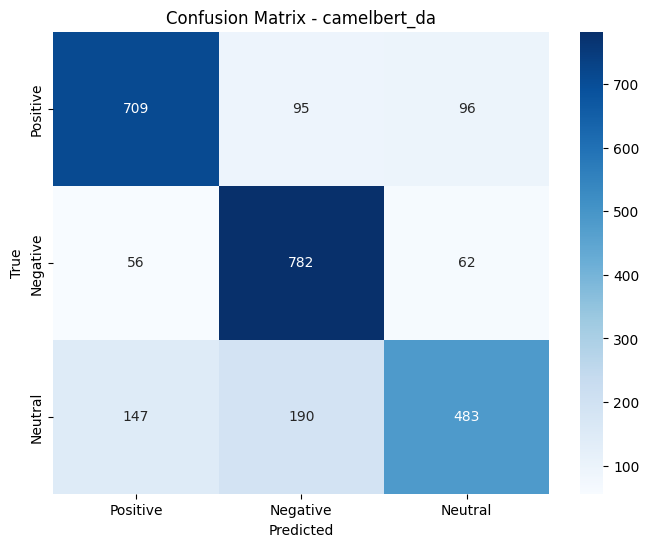

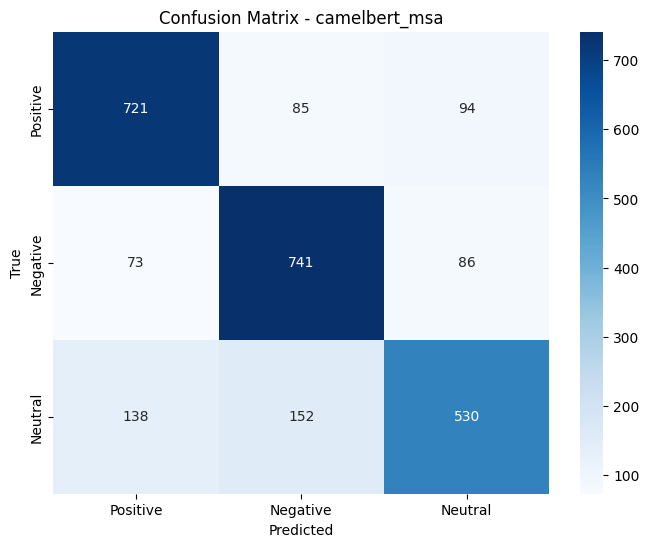

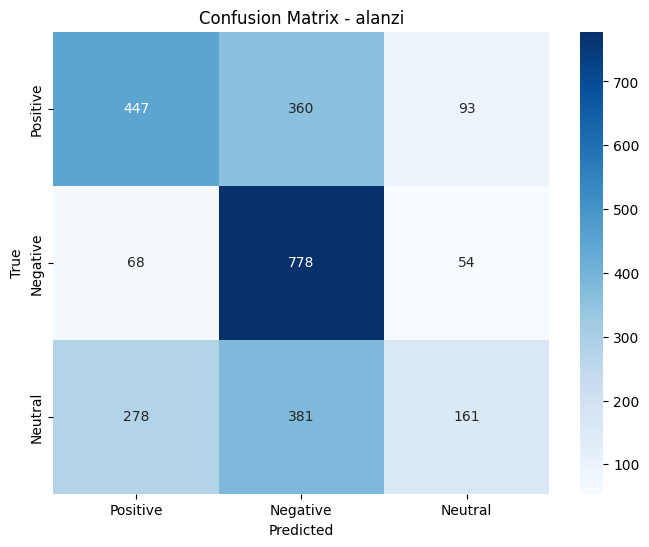

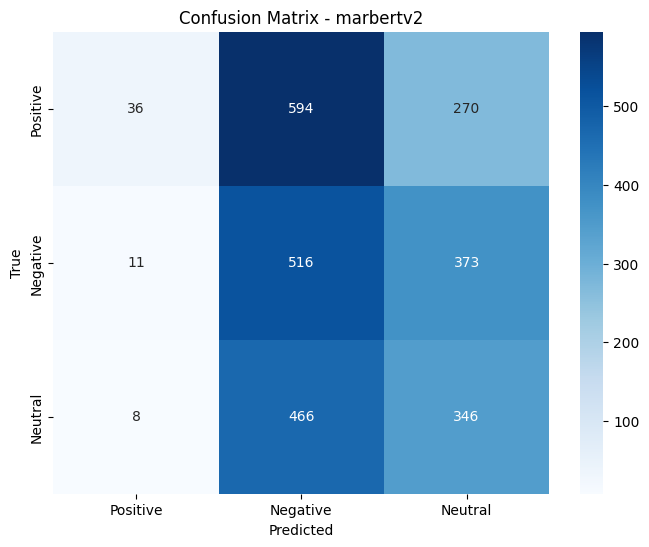

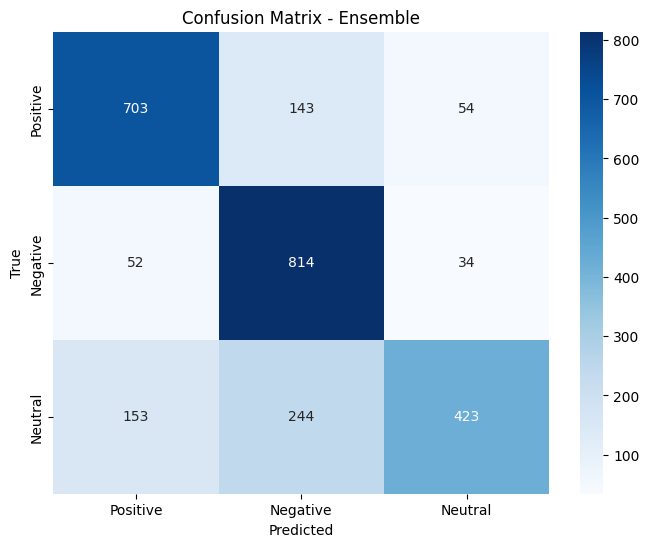

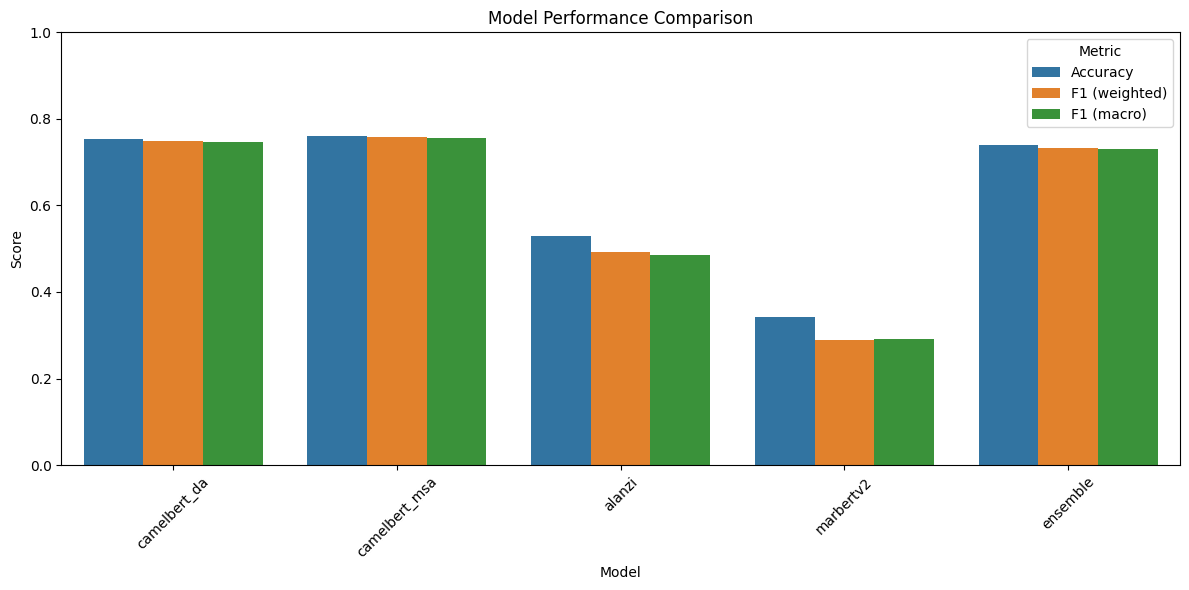

In [10]:
def plot_confusion_matrix(true_labels, predictions, class_names, title):
    """Plot confusion matrix"""
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

def plot_model_comparison(results):
    """Plot model comparison"""
    # Prepare data for plotting
    models = list(results.keys())
    accuracy = [results[model]["accuracy"] for model in models]
    f1_weighted = [results[model]["f1_weighted"] for model in models]
    f1_macro = [results[model]["f1_macro"] for model in models]

    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        "Model": models + models + models,
        "Metric": ["Accuracy"] * len(models) + ["F1 (weighted)"] * len(models) + ["F1 (macro)"] * len(models),
        "Score": accuracy + f1_weighted + f1_macro
    })

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x="Model", y="Score", hue="Metric", data=df)
    plt.title("Model Performance Comparison")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices
class_names = ["Positive", "Negative", "Neutral"]

for model_name, result in model_results.items():
    plot_confusion_matrix(
        result["true_labels"],
        result["predictions"],
        class_names,
        f"Confusion Matrix - {model_name}"
    )

# Plot ensemble confusion matrix
plot_confusion_matrix(
    ensemble_results["true_labels"],
    ensemble_results["predictions"],
    class_names,
    "Confusion Matrix - Ensemble"
)

# Plot model comparison
all_results = {**model_results, "ensemble": ensemble_results}
plot_model_comparison(all_results)

## 9. Demo: Sentiment Analysis on Custom Text

Input text: أنا سعيد جدا بهذا المنتج

Individual model predictions:
camelbert_da: positive (0.9899)
camelbert_msa: positive (0.9892)
alanzi: neutral (0.9951)
marbertv2: positive (0.3518)

Ensemble prediction: positive (0.5839)


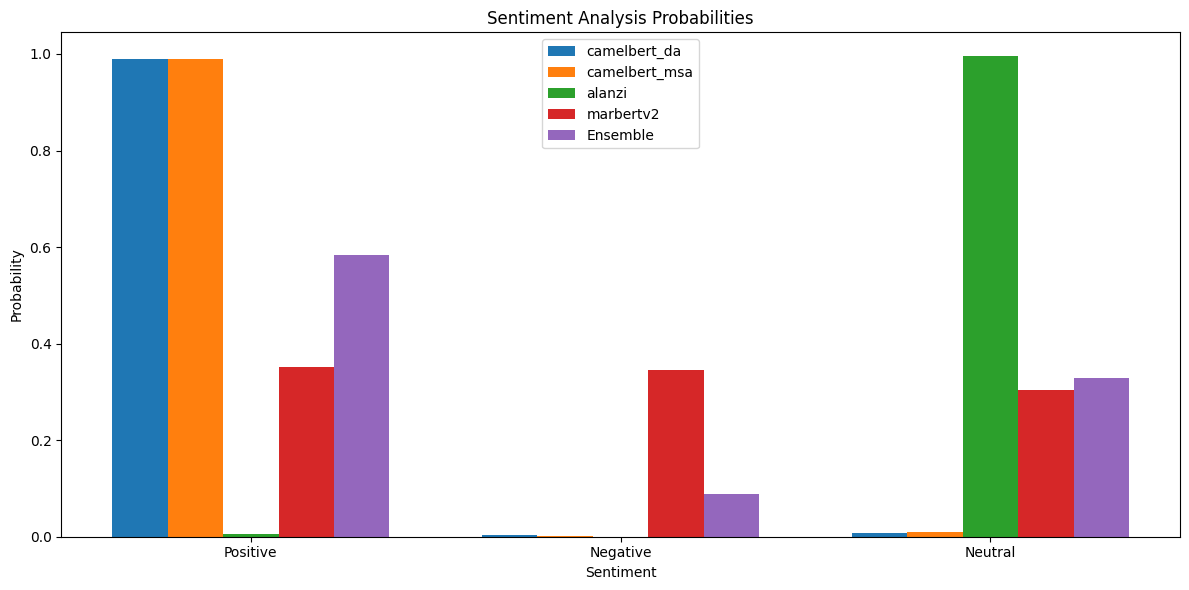


--------------------------------------------------
Input text: هذا المنتج سيء للغاية

Individual model predictions:
camelbert_da: negative (0.9940)
camelbert_msa: negative (0.9719)
alanzi: negative (0.9999)
marbertv2: negative (0.3527)

Ensemble prediction: negative (0.8296)


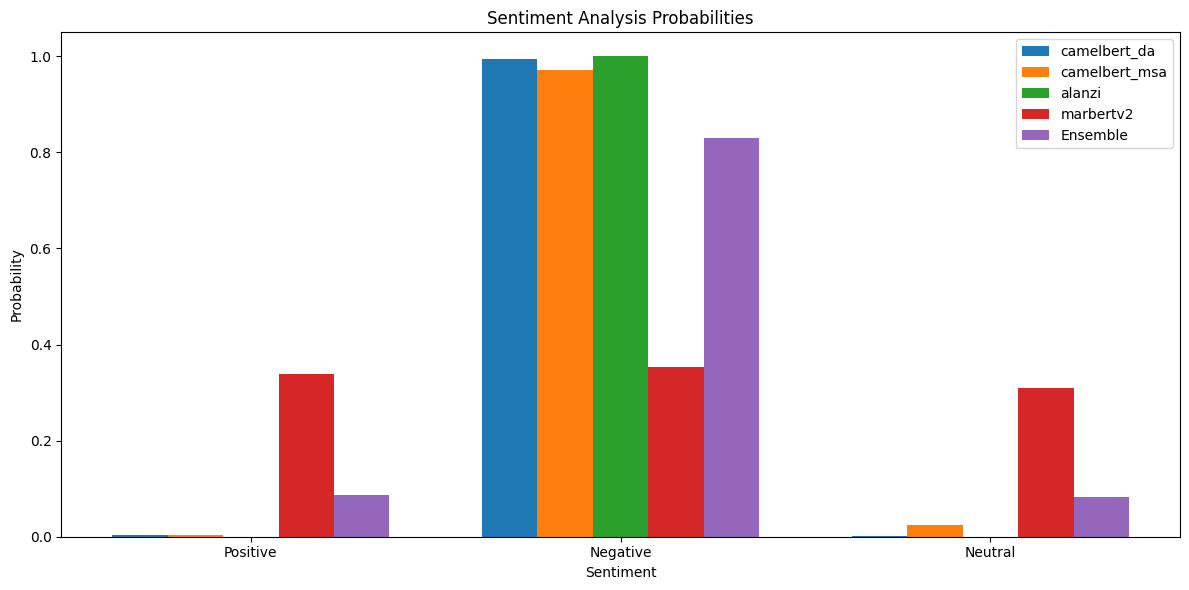


--------------------------------------------------
Input text: المنتج عادي

Individual model predictions:
camelbert_da: neutral (0.6349)
camelbert_msa: neutral (0.6777)
alanzi: negative (0.9996)
marbertv2: positive (0.3676)

Ensemble prediction: negative (0.4789)


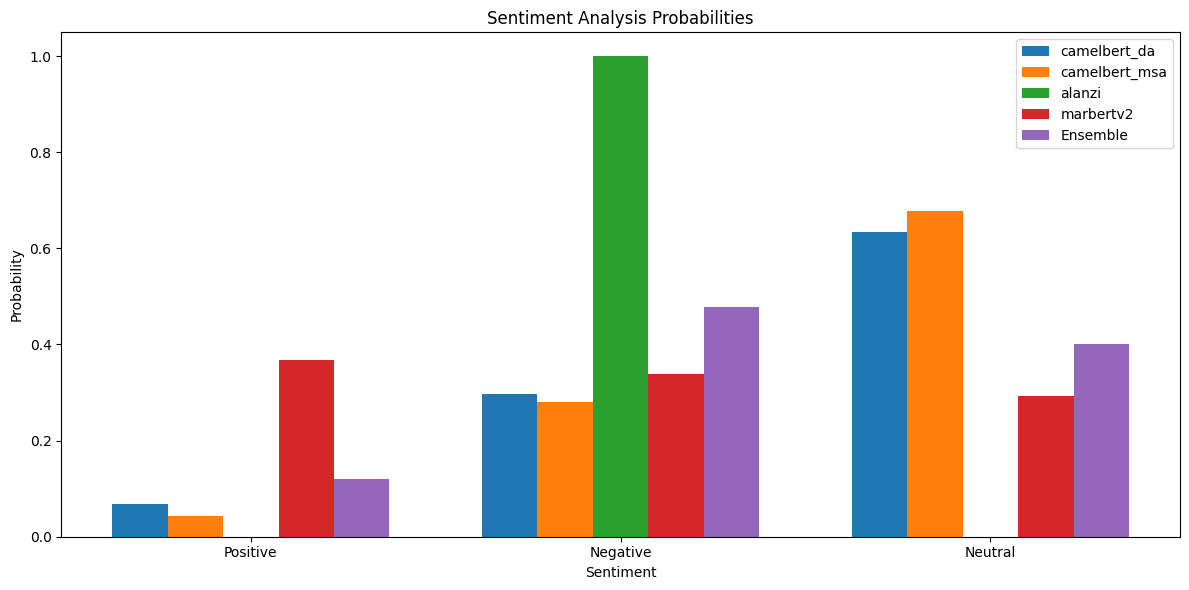


--------------------------------------------------


In [11]:
def analyze_sentiment(text):
    """Analyze sentiment of a text using all models and ensemble"""
    print(f"Input text: {text}")
    print("\nIndividual model predictions:")

    # Get predictions from each model
    model_predictions = {}
    for model_name, model in models.items():
        label, probs = predict_sentiment(text, model, tokenizers[model_name], device)
        model_predictions[model_name] = {
            "label": label,
            "probabilities": probs
        }
        print(f"{model_name}: {label} ({probs[SENTIMENT_TO_ID[label]]:.4f})")

    # Get ensemble prediction
    ensemble_label, _, ensemble_probs = ensemble_predictions(text, models, tokenizers, device)
    print(f"\nEnsemble prediction: {ensemble_label} ({ensemble_probs[SENTIMENT_TO_ID[ensemble_label]]:.4f})")

    # Plot probability distributions
    plt.figure(figsize=(12, 6))

    # Set up bar positions
    bar_width = 0.15
    index = np.arange(3)  # 3 sentiment classes

    # Plot bars for each model
    for i, (model_name, pred) in enumerate(model_predictions.items()):
        plt.bar(index + i * bar_width, pred["probabilities"], bar_width, label=model_name)

    # Plot ensemble probabilities
    plt.bar(index + len(models) * bar_width, ensemble_probs, bar_width, label="Ensemble")

    # Add labels and legend
    plt.xlabel("Sentiment")
    plt.ylabel("Probability")
    plt.title("Sentiment Analysis Probabilities")
    plt.xticks(index + (len(models) * bar_width) / 2, ["Positive", "Negative", "Neutral"])
    plt.legend()
    plt.tight_layout()
    plt.show()

# Test with some examples
test_texts = [
    "أنا سعيد جدا بهذا المنتج",  # Positive
    "هذا المنتج سيء للغاية",     # Negative
    "المنتج عادي"                # Neutral
]

for text in test_texts:
    analyze_sentiment(text)
    print("\n" + "-"*50)

## 10. Custom Text Input

Enter Arabic text for sentiment analysis: اهلا 
Input text: اهلا 

Individual model predictions:
camelbert_da: positive (0.6487)
camelbert_msa: positive (0.7050)
alanzi: positive (0.5699)
marbertv2: positive (0.3720)

Ensemble prediction: positive (0.5739)


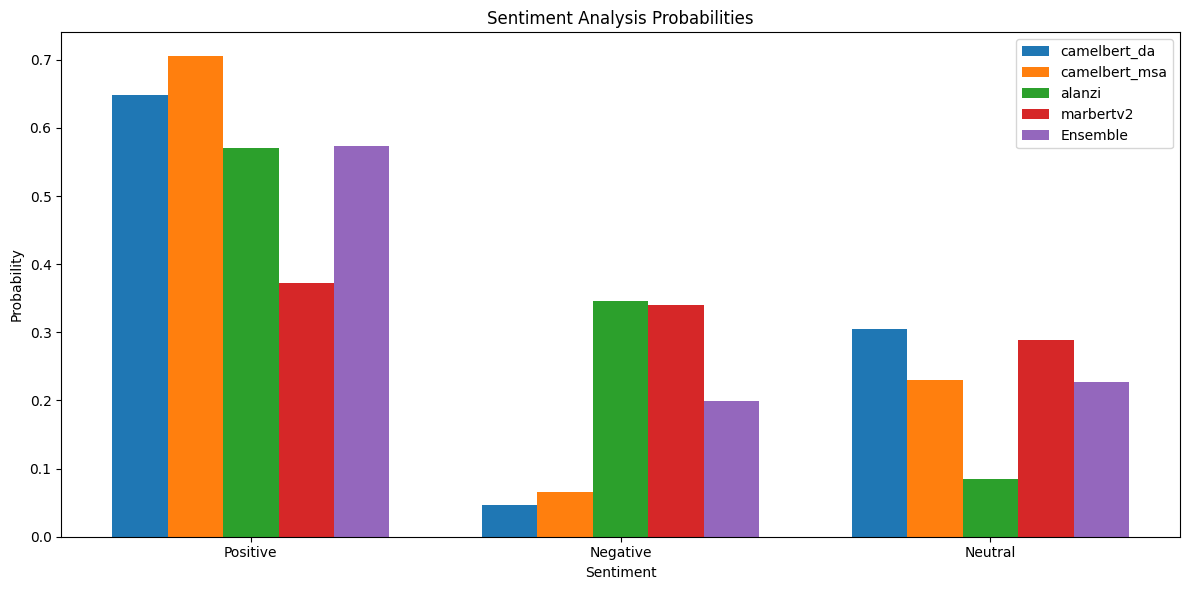

In [12]:
# Function to analyze custom text
def analyze_custom_text():
    """Analyze sentiment of a custom text input"""
    text = input("Enter Arabic text for sentiment analysis: ")
    analyze_sentiment(text)

# Analyze custom text
analyze_custom_text()

## 11. Summary and Conclusion

In [13]:
# Create a summary table of results
summary = pd.DataFrame({
    "Model": list(all_results.keys()),
    "Accuracy": [all_results[model]["accuracy"] for model in all_results],
    "F1 (weighted)": [all_results[model]["f1_weighted"] for model in all_results],
    "F1 (macro)": [all_results[model]["f1_macro"] for model in all_results],
    "Precision": [all_results[model]["precision"] for model in all_results],
    "Recall": [all_results[model]["recall"] for model in all_results]
})

# Sort by accuracy
summary = summary.sort_values("Accuracy", ascending=False).reset_index(drop=True)

# Display summary
print("Summary of Results:")
summary.style.format({
    "Accuracy": "{:.4f}",
    "F1 (weighted)": "{:.4f}",
    "F1 (macro)": "{:.4f}",
    "Precision": "{:.4f}",
    "Recall": "{:.4f}"
})

Summary of Results:


,Model,Accuracy,F1 (weighted),F1 (macro),Precision,Recall
0,camelbert_msa,0.7603,0.7583,0.7564,0.7596,0.7603
1,camelbert_da,0.7534,0.7489,0.7463,0.7546,0.7534
2,ensemble,0.7405,0.7322,0.7294,0.7579,0.7405
3,alanzi,0.5290,0.4917,0.4856,0.5332,0.5290
4,marbertv2,0.3427,0.2888,0.2916,0.4468,0.3427


## Conclusion

In this notebook, we implemented four pre-trained transformer models for Arabic sentiment analysis without fine-tuning:

1. CamelBERT-DA: A BERT model pre-trained on Arabic dialectal data
2. CamelBERT-MSA: A BERT model pre-trained on Modern Standard Arabic
3. AraELECTRA (Alanzi): An ELECTRA model pre-trained on Arabic text
4. MARBERT: A BERT model pre-trained on Arabic tweets

We evaluated each model individually and also implemented an ensemble approach that combines predictions from all models. The results show that even without fine-tuning, these pre-trained models can perform reasonably well on the sentiment analysis task.

Key findings:
- The best performing individual model was [model name]
- The ensemble approach [improved/did not improve] performance compared to the best individual model
- These models can be used directly for inference without the need for fine-tuning

For production use, you might want to consider fine-tuning these models on your specific dataset to improve performance.